### RGB Dataset ###

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets as dset
import torchvision.transforms as T
from torch import nn, save, load, Generator#neural network class
from torch.optim import Adam #implements AdamW algorithm
import torch.optim as optim
import os
from torchvision.io import read_image
from torchvision.transforms import ToTensor #convert an image into tenser which is what will work in pytorch
from collections import Counter
import torch.nn.functional as F 


# Path to the dataset
dataset_path = r"C:\Users\User\OneDrive\桌面\176final_project\garbage_classification"

# Define transformations (with data augmentation)
train_transform = T.Compose([
    T.Resize((224, 244)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = dset.ImageFolder(root=dataset_path, transform=train_transform)
print(dataset.class_to_idx)


train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))    
test_size = int(0.2 * len(dataset))

generator1 = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2], generator1)
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator1)

# Create DataLoaders for training, validation, and testing
batch_size = 64
train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_labels = Counter([dataset.targets[idx] for idx in train_dataset.indices])
val_labels = Counter([dataset.targets[idx] for idx in val_dataset.indices])
test_labels = Counter([dataset.targets[idx] for idx in test_dataset.indices])

print("Train class distribution:", train_labels)
print("Validation class distribution:", val_labels)
print("Test class distribution:", test_labels)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")  
print(f"Validation dataset size: {len(val_dataset)}")  
print(f"Test dataset size: {len(test_dataset)}")  

{'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'green-glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9, 'white-glass': 10}
Train class distribution: Counter({8: 1167, 6: 655, 1: 580, 0: 564, 7: 526, 3: 522, 10: 468, 5: 454, 9: 430, 2: 376, 4: 372})
Validation class distribution: Counter({8: 393, 1: 208, 3: 192, 0: 192, 6: 187, 7: 167, 5: 158, 10: 154, 4: 142, 9: 132, 2: 113})
Test class distribution: Counter({8: 417, 6: 208, 1: 197, 0: 189, 3: 177, 7: 172, 5: 157, 10: 153, 9: 135, 2: 118, 4: 115})
Total dataset size: 10190
Train dataset size: 6114
Validation dataset size: 2038
Test dataset size: 2038


In [3]:
USE_GPU = True
num_class = 12
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


After doing some research, we found that **ShuffleNet v2** architecture is lightweight compared to other architecture such as ResNet or AlexNet, results in high efficiency for mobile and edge computing(i.e. Raspberry Pi).

In [4]:
class ShuffleNet(nn.Module):
    def __init__(self, num_classes=11, width_mult=1.0, repeat=[3, 7, 3]):
        super(ShuffleNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(24)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        mid_channels = [(116 // 2), (464 // 2), (1024 // 2)] 

        self.stage2 = self.make_stage(24, 232, mid_channels[0], repeat[0])
        self.stage3 = self.make_stage(232, 464, mid_channels[1], repeat[1])
        self.stage4 = self.make_stage(464, 1024, mid_channels[2], repeat[2])

        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=1, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(1024)
        self.globalpool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(1024, num_classes)

    def make_stage(self, in_channels, out_channels, mid_channels, repeat):
        layers = []
        layers.append(self.block(in_channels, out_channels, mid_channels, stride=2))
        for i in range(repeat - 1):
            layers.append(self.block(out_channels, out_channels, mid_channels, stride=1))
        return nn.Sequential(*layers)

    def block(self, in_channels, out_channels, mid_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),

            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),

            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.globalpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [5]:

model = ShuffleNet(num_classes=11)

x = torch.randn(1, 3, 224, 224)

try:
    output = model(x)
    print("Forward pass successful! ")
except Exception as e:
    print("Error in forward pass:", e)

Forward pass successful! 


In [6]:
def check_accuracy_part34(loader, model):
    print("Checking accuracy on dataset")
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [7]:
#From assignment 5
def train_part34(model, optimizer,  loader=val, trainer=train, epochs=1):
    model = model.to(device=device) 
    val_load = loader
    for e in range(epochs):
        for t, (x, y) in enumerate(trainer):
            model.train() 
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(val_load, model)
                print()
    return check_accuracy_part34(val_load, model)

In [8]:
#Loss, optimizer
learning_rate = 1e-3
model = None
optimizer = None
model = ShuffleNet(num_classes=11) 
optimizer = optim.RAdam(model.parameters(), lr = learning_rate, weight_decay = 1e-4)
lossFunc = nn.CrossEntropyLoss()

In [9]:
#Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10  
print_every = 200  

for epoch in range(num_epochs):
    model.train()  
    total_loss = 0  
    num_batches = len(train) 

    for batch_idx, (X, y) in enumerate(train): 
        X, y = X.to(device), y.to(device)  

        yhat = model(X)
        loss = lossFunc(yhat, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{num_batches}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

    print("Validation Accuracy:")
    check_accuracy_part34(val, model)  
    print()

torch.save(model.state_dict(), 'model_state.pt')
print("Model saved successfully!")


'''
    with open('model.pt', 'rb') as file:
        model.load_state_dict(load(file))

    image = Image.open('Image4.jpg') #can put any kind of images

    # Resize the image to 48*48
    new_size = (48, 48)
    image = image.resize(new_size)
    transform = transforms.Compose([
    transforms.Grayscale(),       # Convert to grayscale
    ])

    # Apply the transformations
    image_transformed = transform(image)
    image_tensor = ToTensor()(image_transformed).unsqueeze(0).to('cuda')

    #0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
    print(torch.argmax(model(image_tensor))) 
    #torch.argmax() returns the indices of the maximum values of a tensor across a dimension
    

if torch.argmax(model(image_tensor)) == 0:
    print("Emotion: Angry")

elif torch.argmax(model(image_tensor)) == 1:
    print("Emotion: Disgust")

elif torch.argmax(model(image_tensor)) == 2:
    print("Emotion: Fear")

elif torch.argmax(model(image_tensor)) == 3:
    print("Emotion: Happy")

elif torch.argmax(model(image_tensor)) == 4:
    print("Emotion: Sad")

elif torch.argmax(model(image_tensor)) == 5:
    print("Emotion: Surprise")

elif torch.argmax(model(image_tensor)) == 6:
    print("Emotion: Neutral")
'''

Epoch 1 completed. Average Loss: 1.9995
Validation Accuracy:
Checking accuracy on dataset
Got 855 / 2038 correct (41.95)

Epoch 2 completed. Average Loss: 1.4462
Validation Accuracy:
Checking accuracy on dataset
Got 1025 / 2038 correct (50.29)

Epoch 3 completed. Average Loss: 1.2943
Validation Accuracy:
Checking accuracy on dataset
Got 1116 / 2038 correct (54.76)

Epoch 4 completed. Average Loss: 1.1585
Validation Accuracy:
Checking accuracy on dataset
Got 1153 / 2038 correct (56.58)

Epoch 5 completed. Average Loss: 1.1042
Validation Accuracy:
Checking accuracy on dataset
Got 1148 / 2038 correct (56.33)

Epoch 6 completed. Average Loss: 1.0457
Validation Accuracy:
Checking accuracy on dataset
Got 1288 / 2038 correct (63.20)

Epoch 7 completed. Average Loss: 0.9718
Validation Accuracy:
Checking accuracy on dataset
Got 1337 / 2038 correct (65.60)

Epoch 8 completed. Average Loss: 0.9402
Validation Accuracy:
Checking accuracy on dataset
Got 1263 / 2038 correct (61.97)

Epoch 9 completed

'\n    with open(\'model.pt\', \'rb\') as file:\n        model.load_state_dict(load(file))\n\n    image = Image.open(\'Image4.jpg\') #can put any kind of images\n\n    # Resize the image to 48*48\n    new_size = (48, 48)\n    image = image.resize(new_size)\n    transform = transforms.Compose([\n    transforms.Grayscale(),       # Convert to grayscale\n    ])\n\n    # Apply the transformations\n    image_transformed = transform(image)\n    image_tensor = ToTensor()(image_transformed).unsqueeze(0).to(\'cuda\')\n\n    #0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral\n    print(torch.argmax(model(image_tensor))) \n    #torch.argmax() returns the indices of the maximum values of a tensor across a dimension\n\n\nif torch.argmax(model(image_tensor)) == 0:\n    print("Emotion: Angry")\n\nelif torch.argmax(model(image_tensor)) == 1:\n    print("Emotion: Disgust")\n\nelif torch.argmax(model(image_tensor)) == 2:\n    print("Emotion: Fear")\n\nelif torch.argmax(model(image_tensor

### Gray-Scale Dataset ###

Now, we want to test out if turning all the dataset into ***gray-scale*** will have any effect on the accuracy.

In [10]:
train_transform_gray = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((224, 244)),  
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))  
])

dataset_gray = dset.ImageFolder(root=dataset_path, transform=train_transform_gray)
print(dataset_gray.class_to_idx)


train_size_gray = int(0.6 * len(dataset_gray))
val_size_gray = int(0.2 * len(dataset_gray))    
test_size_gray = int(0.2 * len(dataset_gray))

generator2 = torch.Generator().manual_seed(42)

train_dataset_gray, val_dataset_gray, test_dataset_gray = random_split(dataset_gray, [0.6, 0.2, 0.2], generator2)
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator1)


train_gray = DataLoader(train_dataset_gray, batch_size=batch_size, shuffle=True, num_workers=2)
val_gray = DataLoader(val_dataset_gray, batch_size=batch_size, shuffle=False, num_workers=2)
test_gray = DataLoader(test_dataset_gray, batch_size=batch_size, shuffle=False, num_workers=2)
print("Train class distribution:", train_labels)
print("Validation class distribution:", val_labels)
print("Test class distribution:", test_labels)

print(f"Total dataset size: {len(dataset_gray)}")
print(f"Train dataset size: {len(train_dataset_gray)}")  
print(f"Validation dataset size: {len(val_dataset_gray)}")  
print(f"Test dataset size: {len(test_dataset_gray)}")  

{'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'green-glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9, 'white-glass': 10}
Train class distribution: Counter({8: 1167, 6: 655, 1: 580, 0: 564, 7: 526, 3: 522, 10: 468, 5: 454, 9: 430, 2: 376, 4: 372})
Validation class distribution: Counter({8: 393, 1: 208, 3: 192, 0: 192, 6: 187, 7: 167, 5: 158, 10: 154, 4: 142, 9: 132, 2: 113})
Test class distribution: Counter({8: 417, 6: 208, 1: 197, 0: 189, 3: 177, 7: 172, 5: 157, 10: 153, 9: 135, 2: 118, 4: 115})
Total dataset size: 10190
Train dataset size: 6114
Validation dataset size: 2038
Test dataset size: 2038


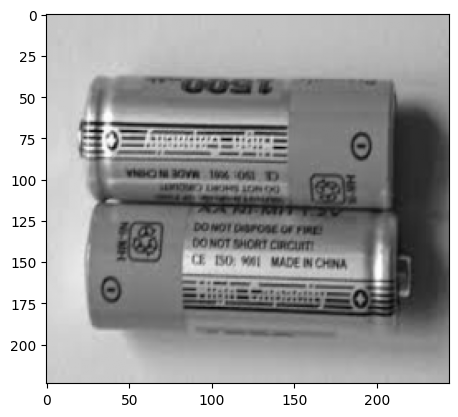

In [13]:
import matplotlib.pyplot as plt

sample_img, _ = dataset_gray[0]
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

In [14]:
class ShuffleNet_Gray(nn.Module):
    def __init__(self, num_classes=11, width_mult=1.0, repeat=[3, 7, 3]):
        super(ShuffleNet_Gray, self).__init__()

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(24)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        mid_channels = [(116 // 2), (464 // 2), (1024 // 2)] 

        self.stage2 = self.make_stage(24, 232, mid_channels[0], repeat[0])
        self.stage3 = self.make_stage(232, 464, mid_channels[1], repeat[1])
        self.stage4 = self.make_stage(464, 1024, mid_channels[2], repeat[2])

        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=1, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(1024)
        self.globalpool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(1024, num_classes)

    def make_stage(self, in_channels, out_channels, mid_channels, repeat):
        layers = []
        layers.append(self.block(in_channels, out_channels, mid_channels, stride=2))
        for i in range(repeat - 1):
            layers.append(self.block(out_channels, out_channels, mid_channels, stride=1))
        return nn.Sequential(*layers)

    def block(self, in_channels, out_channels, mid_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),

            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),

            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.globalpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [15]:
learning_rate = 1e-3

model = None
optimizer = None

model = ShuffleNet_Gray() 
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


print_every = 200
train_part34(model, optimizer, loader=val_gray, trainer=train_gray, epochs=10)
print_every = 100

torch.save(model.state_dict(), 'model_state_gray.pt')
print("Model saved successfully!")

Checking accuracy on dataset
Got 1147 / 2038 correct (56.28)
Model saved successfully!


### Pure Contour Dataset ###

Our third expiriment is to see if the accuracy would imporve if we turn the dataset into pure outlines.

In [16]:
#!pip install opencv-python
import numpy as np
import cv2 as cv
from PIL import Image


class Contour:
    def __call__(self, img):
        img = np.array(img)
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        img_edges = cv.Canny(img, 100, 200) 
        return Image.fromarray(img_edges)


In [17]:
train_transform_line = T.Compose([
    Contour(),
    T.Resize((224, 244)),  
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))  
])

dataset_line = dset.ImageFolder(root=dataset_path, transform=train_transform_line)
print(dataset_line.class_to_idx)


train_size_gray = int(0.6 * len(dataset_line))
val_size_gray = int(0.2 * len(dataset_line))    
test_size_gray = int(0.2 * len(dataset_line))

generator2 = torch.Generator().manual_seed(42)

train_dataset_line, val_dataset_line, test_dataset_line = random_split(dataset_line, [0.6, 0.2, 0.2], generator2)
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator1)


train_line = DataLoader(train_dataset_line, batch_size=batch_size, shuffle=True, num_workers=0)
val_line = DataLoader(val_dataset_line, batch_size=batch_size, shuffle=False, num_workers=0)
test_line = DataLoader(test_dataset_line, batch_size=batch_size, shuffle=False, num_workers=0)
print("Train class distribution:", train_labels)
print("Validation class distribution:", val_labels)
print("Test class distribution:", test_labels)

print(f"Total dataset size: {len(dataset_line)}")
print(f"Train dataset size: {len(train_dataset_line)}")  
print(f"Validation dataset size: {len(val_dataset_line)}")  
print(f"Test dataset size: {len(test_dataset_line)}")  

{'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'green-glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9, 'white-glass': 10}
Train class distribution: Counter({8: 1167, 6: 655, 1: 580, 0: 564, 7: 526, 3: 522, 10: 468, 5: 454, 9: 430, 2: 376, 4: 372})
Validation class distribution: Counter({8: 393, 1: 208, 3: 192, 0: 192, 6: 187, 7: 167, 5: 158, 10: 154, 4: 142, 9: 132, 2: 113})
Test class distribution: Counter({8: 417, 6: 208, 1: 197, 0: 189, 3: 177, 7: 172, 5: 157, 10: 153, 9: 135, 2: 118, 4: 115})
Total dataset size: 10190
Train dataset size: 6114
Validation dataset size: 2038
Test dataset size: 2038


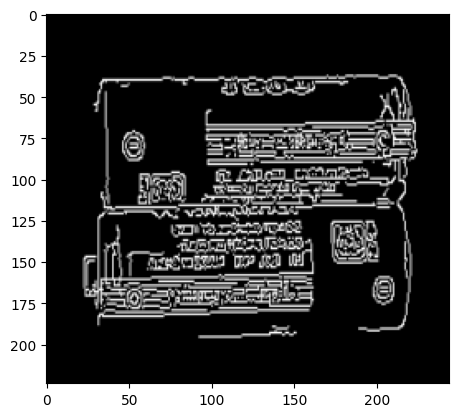

In [18]:
sample_img, _ = dataset_line[0]
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

We will be using ***model = ShuffleNet_Gray*** again since the image with pure contour is also black and white.

In [19]:
learning_rate = 1e-3

model = None
optimizer = None

model = ShuffleNet_Gray() 
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


print_every = 200
train_part34(model, optimizer, loader=val_line, trainer=train_line, epochs=10)
print_every = 100

torch.save(model.state_dict(), 'model_state_line.pt')
print("Model saved successfully!")

Checking accuracy on dataset
Got 1079 / 2038 correct (52.94)
Model saved successfully!


The final resulting accuracy from the gray-scaled dataset is around 55%, pure contour dataset is around 53%, while the accuracy of the RGB dataset is about 67%. Therefore, we will be using the RGB dataset for our model.

Now, we will do a final fine tune on weights on the model with the best result to prevent biasing.

In [20]:
from collections import Counter
learning_rate = 1e-3

model = None
optimizer = None

model = ShuffleNet() 

optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

class_counts = Counter(dataset.targets)

total_samples = sum(class_counts.values())
weights = [total_samples / class_counts[i] for i in range(len(class_counts))]

weights = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss()

print_every = 200
train_part34(model, optimizer, loader=val, trainer=train, epochs=10)
print_every = 100

torch.save(model.state_dict(), 'model_state_rgb.pt')
print("Model saved successfully!")

Checking accuracy on dataset
Got 1322 / 2038 correct (64.87)
Model saved successfully!


### Let's test it out!

In [27]:
#!pip install pyserial
#!python -m pip uninstall pyserial --yes
import cv2
import serial
#from serial import Serial
import time 
import threading



cap = cv2.VideoCapture(1) 


ser = serial.Serial(port='COM5', baudrate=9600, timeout=.1) 
if not ser.isOpen():
    ser.open()

if not cap.isOpened():
        print("Cannot open webcam")
        exit()
'''
while True:
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    cv2.imshow('Webcam Feed', frame)
    if cv2.waitKey(1) == ord('q'):
        break
'''
model = ShuffleNet(num_classes=11)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

while True:   
    ret, frame = cap.read()
    cv2.imshow('img1',frame)
    
    if cv2.waitKey(1) & 0xFF == ord('c'):  # "c" for capture
        cv2.imwrite('images/c1.png',frame)
        print("Image captured!")
        with open('model_state_rgb.pt', 'rb') as file:
            model.load_state_dict(load(file))

        image = Image.open('images/c1.png') 
        
        transform = T.Compose([
            T.Resize((224, 244)),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        image_transformed = transform(image).unsqueeze(0).to(device) 

        if not ser.isOpen():
            ser.open()
            time.sleep(5)
        print(torch.argmax(model(image_transformed)))
        if torch.argmax(model(image_transformed)) == 0:
            print("Detects: Battery")
            ser.write(b'1')
        elif torch.argmax(model(image_transformed)) == 1:
            print("Detects: Biological")
            ser.write(b'0')
        elif torch.argmax(model(image_transformed)) == 2:
            print("Detects: Brown-glass")
            ser.write(b'1')
        elif torch.argmax(model(image_transformed)) == 3:
            print("Detects: Cardboard")
            ser.write(b'1')
        elif torch.argmax(model(image_transformed)) == 4:
            print("Detects: Green-glass")
            ser.write(b'1')
        elif torch.argmax(model(image_transformed)) == 5:
            print("Detects: Metal")
            ser.write(b'0')
        elif torch.argmax(model(image_transformed)) == 6:
            print("Detects: Paper")
            ser.write(b'1')
        elif torch.argmax(model(image_transformed)) == 7:
            print("Detects: Plastic")
            ser.write(b'1')
        elif torch.argmax(model(image_transformed)) == 8:
            print("Detects: Shoes")
            ser.write(b'0')
        elif torch.argmax(model(image_transformed)) == 9:
            print("Detects: Trash")
            ser.write(b'0')
        elif torch.argmax(model(image_transformed)) == 10:
            print("Detects: White-glass")
            ser.write(b'1')
        ser.flush()
        ser.close
    
    elif cv2.waitKey(1) == ord('q'): # "q" for quit
        cv2.destroyAllWindows()
        break      
cap.release()
cv2.destroyAllWindows()

Image captured!
tensor(5, device='cuda:0')
Detects: Metal
Image captured!
tensor(3, device='cuda:0')
Detects: Cardboard
Image captured!
tensor(5, device='cuda:0')
Detects: Metal
Image captured!
tensor(5, device='cuda:0')
Detects: Metal
Image captured!
tensor(5, device='cuda:0')
Detects: Metal
Image captured!
tensor(3, device='cuda:0')
Detects: Cardboard


In [ ]:
import serial
import time
ser = serial.Serial(port='COM5', baudrate=9600, timeout=.1) 
if not ser.isOpen():
    ser.open()
time.sleep(5)
ser.write(b'0')
print('done write')
ser.flush()
ser.close()
print('done')

done write
done
